In [ ]:
%%capture
!pip install --upgrade diffusers transformers accelerate scipy safetensors peft

In [2]:
import torch
from diffusers import AnimateDiffPipeline, LCMScheduler, MotionAdapter
from diffusers.utils import export_to_gif

adapter = MotionAdapter.from_pretrained("wangfuyun/AnimateLCM", torch_dtype=torch.float16)
pipe = AnimateDiffPipeline.from_pretrained("emilianJR/epiCRealism", motion_adapter=adapter, torch_dtype=torch.float16)
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config, beta_schedule="linear")

pipe.load_lora_weights("wangfuyun/AnimateLCM", weight_name="AnimateLCM_sd15_t2v_lora.safetensors", adapter_name="lcm-lora")
pipe.set_adapters(["lcm-lora"], [0.8])

# pipe.enable_vae_slicing()
# pipe.enable_model_cpu_offload()
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\gujih\miniconda3\envs\taesdv\Lib\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [3]:
# construct TAESDV and set up previewing callback
from taesdv import TAESDV
import torchvision.transforms.functional as TF
import io
import base64
from IPython.display import HTML

taesdv = TAESDV("../taesdv.pth").half().cuda()

def get_pred_original_sample(sched, model_output, timestep, sample):
    alpha_prod_t = sched.alphas_cumprod[timestep]
    return (sample - (1 - alpha_prod_t) ** 0.5 * model_output) / alpha_prod_t ** 0.5

preview_handle = None

def frames_to_html(frames):
    """Display TCHW [0, 1] frame tensor as inline video on colab."""
    assert frames.ndim == 4 and frames.shape[1] == 3 # TCHW
    frames = [TF.to_pil_image(f) for f in frames.clamp_(0, 1).mul_(255).round_().byte().cpu()]
    video_buff = io.BytesIO()
    frames[0].save(video_buff, append_images=frames[1:], save_all=True, duration_ms=1000/30, loop=0, format="GIF")
    video_buff.seek(0)
    video_b64 = base64.b64encode(video_buff.getvalue()).decode('utf-8')
    return HTML(f"<img src='data:image/gif;base64,{video_b64}'/>")

def add_taesd_previewing(pipe, taesdv):
    sched = pipe.scheduler
    if not hasattr(sched, "_step"):
        sched._step = sched.step
    @torch.no_grad()
    def step_and_preview(*args, **kwargs):
        global preview_images, preview_handle
        latents = get_pred_original_sample(sched, *args)
        # latents are NCTHW, transpose to NTCHW for TAESDV
        decoded_frames = taesdv.decode_video(latents.transpose(1, 2))
        decoded_video = frames_to_html(decoded_frames[0])
        if preview_handle is None:
            preview_handle = display(decoded_video, display_id=True)
        else:
            preview_handle.update(decoded_video)
        return sched._step(*args, **kwargs)
    sched.step = step_and_preview

add_taesd_previewing(pipe, taesdv)

In [16]:
print("Live previewing with TAESDV")
output = pipe(
    prompt="An adorable bunny exploring a strawberry garden on a beautiful sunny day",
    negative_prompt="bad quality, worse quality, low resolution",
    num_frames=16,
    guidance_scale=3.0,
    num_inference_steps=15,
    generator=torch.Generator("cpu").manual_seed(0),
)

Live previewing with TAESDV


  0%|          | 0/15 [00:00<?, ?it/s]

Final result (per-frame SD-VAE decode)



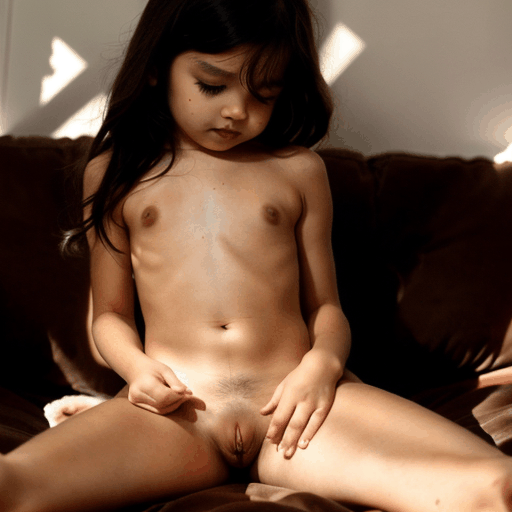

In [17]:
print("Final result (per-frame SD-VAE decode)")
def show_gif_in_notebook(gif_file_path):
    with open(gif_file_path, "rb") as gif_file:
        data = base64.b64encode(gif_file.read())
    display(HTML(f"<img src='data:image/gif;base64,{data.decode('utf-8')}'/>"))
frames = output.frames[0]
export_to_gif(frames, "animatelcm.gif")
show_gif_in_notebook("animatelcm.gif")